# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

# Gary Schulke
# Observations
## Observation 1
The northern hemisphere is better represented that the southern hemisphere.  On the graphs, the norther hemisphere is shown on the right with the positive latitude values.   The density of the data on the right side of the graph is evident in all four graphs.  Does this matter.  If the purpose of the data analysis is to examine weather in human populated areas it may be showing what is wanted.  If the purpose is global climate in nature, a better sampling method may be needed. 
## Observation 2
Latitude vs Temp
Maximum temperatures are not centered at the equator.  Different data samples produced different results but in all samples the area of +/-20 degrees is the range where the maximum temperatures occur.  I ran the program multiple time and noticed consistent dip at 0 degrees latitude.
## Observation 3
The plotted information is inadequate for the Cloudiness data to be meaningful.  To get any meaningful information from this it would be necessary to understand how cloudiness is measured and categorized and use that in the data analysis.
## Purpose of Citipi
The question was asked in the instructions on what the purpose of the Citipi library might be.  While coding the assignment I experimented with the API using the generated latitudes and longitudes directly in the API call.  The calls to the API worked fine but with ¾ of the earth covered in water, many of the calls to the API came back with the location not found error.  This is a huge waste of time.  Citipi along with the loop looking up each lat-lng combination filters out most the locations that can’t be found.

### Implementation Notes.
Because I find it personal interesting, I tracked some performance data that is printed to the last cell in the notebook.

### Files Submitted
The output files are in the “/output_data” folder.<br>
Files: <br>
 output_data/cities.csv<br>
 output_data/CityLatvsHumidity.png<br>
 output_data/CityLatvsWindSpeed.png<br>
 output_data/CityLatvsCloudiness.png<br>
 output_data/CityLatvsMaxTemperature.png<br>
 WeatherPy.ipynb<br>



In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time

# Import API key
from api_keys import api_key

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)

## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []
units = "Imperial"
url = "http://api.openweathermap.org/data/2.5/weather?"
url = url + "appid=" + api_key + f"&units={units}"
df_columns = ["City", "ID", "Cloudiness", "Country", "Date", "Humidity", "Lat", "Lng", "Max Temp", "Wind Speed"]
composite_df = pd.DataFrame()

# Create a set of random lat and lng combinations
lats = np.random.uniform(low=-90.000, high=90.000, size=1500)
lngs = np.random.uniform(low=-180.000, high=180.000, size=1500)
lat_lngs = zip(lats, lngs)
        
# Identify nearest city for each lat, lng combination
# Modified to get country code.
for lat, lng in lat_lngs:
    city = citipy.nearest_city(lat, lng).city_name
    country = citipy.nearest_city(lat, lng).country_code

    # If the city+country is unique, then add it to a our cities list
    if (city,country) not in cities:
        cities.append((city, country))
        
# Print the city count to confirm sufficient count
print (f"{len(cities)} city+country locations have been generated.")  

627 city+country locations have been generated.


In [3]:
# Creates a DataFrame from the json returned by the api.
# data_json - The data returned from the api call.
# returns a pandas DataFrame
# Exceptions - an exception will return an empty dataframe.
def make_dataframe(data_json):
    # A list of lists for df creation
    #print(data_json)
    adf = pd.DataFrame()
    try:
        datalist = [[data_json["name"], data_json["id"], data_json["clouds"]["all"], data_json["sys"]["country"], data_json['dt'],
                    data_json["main"]["humidity"], data_json['coord']["lat"], data_json['coord']["lon"], 
                    data_json['main']["temp_max"], data_json['wind']["speed"]]]
        adf = pd.DataFrame(datalist, columns=df_columns)
    except Exception as err:
        print(err)
    return adf


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).

### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [4]:
# This loops through the list of cities to a maximum of max_cities.
# Weather is looked up by city and country an put into a pandas DataFrame.
# The number of  cities sampled can be changed by setting man_cities.  
# The loop will run until max_cities is reached or every entry in cities has been exhausted.
max_cities = 500
success_counter = 0
fail_counter = 0
delay = 1   
delaylist = []  
for acity, acountry in cities:
    delaylist.append(delay)
    
    time.sleep(delay)   # The maximum rate to make api calls on openweathermap is 1 second.
                        # The time it takes to process the loop can be deducted from the wait time.
    loop_start_time = time.time()

    query_url = url + f"&q={acity},{acountry}"
    try:
        response_json = requests.get(query_url).json()
        return_code = response_json['cod']
    except Exception as err:
        print (err)
        return_code = 0
    pandas_start = time.time()    
    if (return_code == 200):
        return_name = response_json["name"]
        
        if (len(return_name) > 0):
            new_df = make_dataframe(response_json)
            
            if not (new_df.empty):    
                if (composite_df.empty):
                    composite_df = new_df
                else:
                    composite_df = composite_df.append(new_df, ignore_index=True)
            
            success_counter += 1
            ret_city_id = new_df.at[0, "ID"]
            ret_coun = new_df.at[0, "Country"]
            ret_city = new_df.at[0, "City"]
            
            print(f"Query Number: {success_counter}. Return code: {return_code}. For {ret_city}, {ret_coun}, {ret_city_id} .")
            print(query_url) 
        else:
            print(f"Query Fails: {fail_counter}. Return code: {return_code}. No name returned for {acity}, {acountry}.")
            print(query_url)   
            fail_counter += 1
    
    elif (return_code == 0):
        print("Error reading from API")
    
    else:
        print(f"Query Fails: {fail_counter}. Return code: {return_code} No data returned for {acity}, {acountry}.")
        print(query_url)  
        fail_counter += 1    
    
    loop_end_time = time.time()
    delay = 1 - (loop_end_time - loop_start_time)
    delay = max([delay, 0])    # If the api call is > 1 second calculated delay could be < 0

    if success_counter >= max_cities:
        break
        
composite_df.reset_index()
data_date = time.strftime("%m/%d/%y")   

try:
    composite_df.to_csv(output_data_file)
except:
    print(f"Unable to write file: {output_data_file}")
          

Query Number: 1. Return code: 200. For Tasiilaq, GL, 3424607 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=tasiilaq,gl
Query Number: 2. Return code: 200. For Sechura, PE, 3691954 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=sechura,pe
Query Number: 3. Return code: 200. For Rikitea, PF, 4030556 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=rikitea,pf
Query Number: 4. Return code: 200. For Atuona, PF, 4020109 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=atuona,pf
Query Number: 5. Return code: 200. For Kurchum, KZ, 1521762 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=kurchum,kz
Query Number: 6. Return code: 200. For Nanortalik, GL, 3421765 .
http://api.openweathermap.org/data/2.5/weather?appid=04

Query Fails: 5. Return code: 404 No data returned for samusu, ws.
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=samusu,ws
Query Number: 42. Return code: 200. For Bembereke, BJ, 2395182 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=bembereke,bj
Query Number: 43. Return code: 200. For Hofn, IS, 2630299 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=hofn,is
Query Number: 44. Return code: 200. For Busselton, AU, 2075265 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=busselton,au
Query Fails: 6. Return code: 404 No data returned for illoqqortoormiut, gl.
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=illoqqortoormiut,gl
Query Number: 45. Return code: 200. For Avarua, CK, 4035715 .
http://api.openweathermap.o

Query Number: 83. Return code: 200. For Aykhal, RU, 2027296 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=aykhal,ru
Query Number: 84. Return code: 200. For New Norfolk, AU, 2155415 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=new norfolk,au
Query Number: 85. Return code: 200. For Labuan, MY, 1734240 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=labuan,my
Query Number: 86. Return code: 200. For Arlit, NE, 2447513 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=arlit,ne
Query Number: 87. Return code: 200. For Acapulco, MX, 3533462 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=acapulco,mx
Query Number: 88. Return code: 200. For Lyubinskiy, RU, 1500125 .
http://api.openweathermap.org/data/2.5/weather?

Query Number: 122. Return code: 200. For Souillac, MU, 933995 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=souillac,mu
Query Number: 123. Return code: 200. For Tiksi, RU, 2015306 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=tiksi,ru
Query Number: 124. Return code: 200. For Arraial do Cabo, BR, 3471451 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=arraial do cabo,br
Query Number: 125. Return code: 200. For Yerofey Pavlovich, RU, 2012938 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=yerofey pavlovich,ru
Query Number: 126. Return code: 200. For Nome, US, 4732862 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=nome,us
Query Fails: 17. Return code: 404 No data returned for emba, kz.
http://api.openwea

Query Number: 161. Return code: 200. For Ust-Kuyga, RU, 2013921 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=ust-kuyga,ru
Query Number: 162. Return code: 200. For Abalak, NE, 2448245 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=abalak,ne
Query Number: 163. Return code: 200. For Blackwater, AU, 2175403 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=blackwater,au
Query Number: 164. Return code: 200. For Cockburn Town, TC, 3576994 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=cockburn town,tc
Query Fails: 24. Return code: 404 No data returned for khor, qa.
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=khor,qa
Query Number: 165. Return code: 200. For Anchorage, US, 5879400 .
http://api.openweathermap.

Query Number: 202. Return code: 200. For Clyde River, CA, 5924351 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=clyde river,ca
Query Number: 203. Return code: 200. For Tazmalt, DZ, 2477537 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=tazmalt,dz
Query Number: 204. Return code: 200. For Cayenne, GF, 3382160 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=cayenne,gf
Query Fails: 29. Return code: 404 No data returned for attawapiskat, ca.
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=attawapiskat,ca
Query Number: 205. Return code: 200. For Gari, RU, 1506676 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=gari,ru
Query Number: 206. Return code: 200. For Cururupu, BR, 3401148 .
http://api.openweathermap.org

Query Number: 241. Return code: 200. For Arrecife, ES, 2521570 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=arrecife,es
Query Number: 242. Return code: 200. For Mahibadhoo, MV, 1337605 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=mahibadhoo,mv
Query Number: 243. Return code: 200. For Funadhoo, MV, 1337620 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=funadhoo,mv
Query Fails: 35. Return code: 404 No data returned for mys shmidta, ru.
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=mys shmidta,ru
Query Number: 244. Return code: 200. For Pumiao, CN, 1798480 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=pumiao,cn
Query Number: 245. Return code: 200. For Labuhan, ID, 1641899 .
http://api.openweathermap.

Query Number: 279. Return code: 200. For Itupiranga, BR, 3397851 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=itupiranga,br
Query Number: 280. Return code: 200. For Shelburne, CA, 6145890 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=shelburne,ca
Query Number: 281. Return code: 200. For Rongcheng, CN, 1786855 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=rongcheng,cn
Query Number: 282. Return code: 200. For Kyra, RU, 2021041 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=kyra,ru
Query Number: 283. Return code: 200. For Pangody, RU, 1495626 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=pangody,ru
Query Number: 284. Return code: 200. For Saint George, BM, 3573061 .
http://api.openweathermap.org/dat

Query Number: 322. Return code: 200. For Georgetown, SH, 2411397 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=georgetown,sh
Query Number: 323. Return code: 200. For Shimoda, JP, 1852357 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=shimoda,jp
Query Number: 324. Return code: 200. For Myingyan, MM, 1307835 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=myingyan,mm
Query Number: 325. Return code: 200. For Yumen, CN, 1528998 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=yumen,cn
Query Number: 326. Return code: 200. For Kipia, GR, 735861 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=kipia,gr
Query Number: 327. Return code: 200. For Shingu, JP, 1847947 .
http://api.openweathermap.org/data/2.5/weather?a

Query Number: 362. Return code: 200. For Lincoln, US, 5072006 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=lincoln,us
Query Number: 363. Return code: 200. For Son Tay, VN, 1567621 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=son tay,vn
Query Number: 364. Return code: 200. For San Felipe, MX, 3987224 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=san felipe,mx
Query Fails: 52. Return code: 404 No data returned for mormugao, in.
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=mormugao,in
Query Number: 365. Return code: 200. For Adrar, DZ, 2508813 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=adrar,dz
Query Number: 366. Return code: 200. For Cherskiy, RU, 2126199 .
http://api.openweathermap.org/data/2.

Query Fails: 57. Return code: 404 No data returned for asau, tv.
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=asau,tv
Query Number: 403. Return code: 200. For Richards Bay, ZA, 962367 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=richards bay,za
Query Number: 404. Return code: 200. For Kajaani, FI, 654901 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=kajaani,fi
Query Number: 405. Return code: 200. For Progreso, MX, 3515690 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=progreso,mx
Query Number: 406. Return code: 200. For Buraydah, SA, 107304 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=buraydah,sa
Query Number: 407. Return code: 200. For Mason City, US, 4866445 .
http://api.openweathermap.org/data

Query Fails: 59. Return code: 404 No data returned for dzhusaly, kz.
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=dzhusaly,kz
Query Number: 447. Return code: 200. For El Limon, VE, 3642833 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=el limon,ve
Query Number: 448. Return code: 200. For Lazaro Cardenas, MX, 3996234 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=lazaro cardenas,mx
Query Number: 449. Return code: 200. For Amambai, BR, 3472391 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=amambai,br
Query Number: 450. Return code: 200. For Tramandai, BR, 3446232 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=tramandai,br
Query Number: 451. Return code: 200. For Shibetsu, JP, 2127500 .
http://api.openwe

Query Fails: 70. Return code: 404 No data returned for malwan, in.
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=malwan,in
Query Number: 482. Return code: 200. For Redmond, US, 5808079 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=redmond,us
Query Fails: 71. Return code: 404 No data returned for fierze, al.
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=fierze,al
Query Number: 483. Return code: 200. For Sirohi, IN, 1256067 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=sirohi,in
Query Number: 484. Return code: 200. For Springdale, CA, 6154159 .
http://api.openweathermap.org/data/2.5/weather?appid=042140631b66d91bbdb048ed0e632c1c&units=Imperial&q=springdale,ca
Query Number: 485. Return code: 200. For Ishigaki, JP, 1861416 .
http://api.openweathermap.org/data/2.

### Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

#### Latitude vs. Temperature Plot

In [5]:
temps = composite_df["Max Temp"]
lats = composite_df["Lat"]

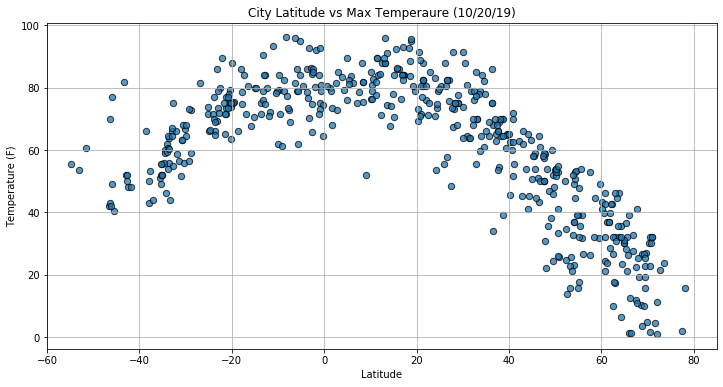

In [14]:
plt.figure(figsize=(12,6))
plt.scatter(lats, temps, marker="o", facecolors="tab:blue", edgecolors="black", s=40, alpha=0.75)
plt.xlabel("Latitude")
plt.ylabel("Temperature (F)")
plt.title(f"City Latitude vs Max Temperaure ({data_date})")
plt.xlim(-60, 85)
#plt.ylim(-10, 110)
plt.grid()
plt.savefig('output_data/CityLatvsMaxTemperature.png')
plt.show()

#### Latitude vs. Humidity Plot

In [7]:
humidities = composite_df["Humidity"]
lats = composite_df["Lat"]

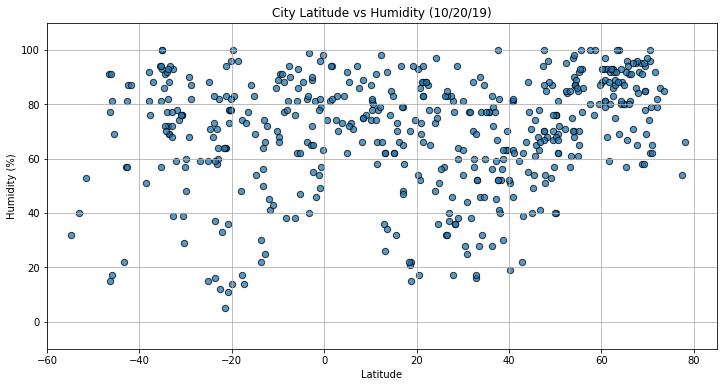

In [15]:
plt.figure(figsize=(12,6))
plt.scatter(lats, humidities, marker="o", facecolors="tab:blue", edgecolors="black", s=40, alpha=0.75)
plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
plt.title(f"City Latitude vs Humidity ({data_date})")
plt.xlim(-60, 85)
plt.ylim(-10, 110)
plt.grid()
plt.savefig('output_data/CityLatvsHumidity.png')
plt.show()

#### Latitude vs. Cloudiness Plot

In [9]:
cloudiness = composite_df["Cloudiness"]
lats = composite_df["Lat"]

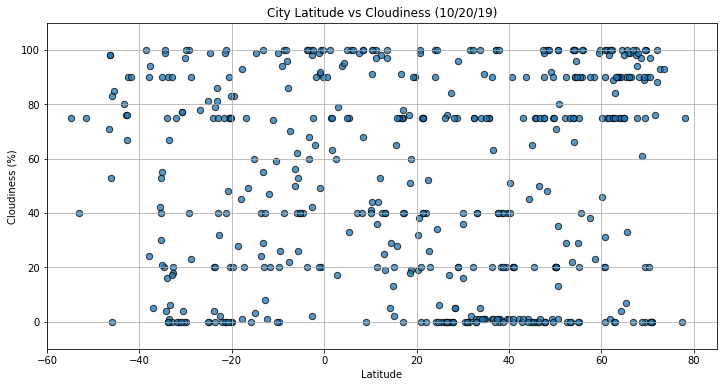

In [16]:
plt.figure(figsize=(12,6))
plt.scatter(lats, cloudiness, marker="o", facecolors="tab:blue", edgecolors="black", s=40, alpha=0.75)
plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
plt.title(f"City Latitude vs Cloudiness ({data_date})")
plt.xlim(-60, 85)
plt.ylim(-10, 110)
plt.grid()
plt.savefig('output_data/CityLatvsCloudiness.png')
plt.show()

#### Latitude vs. Wind Speed Plot

In [11]:
windspeed = composite_df["Wind Speed"]
lats = composite_df["Lat"]

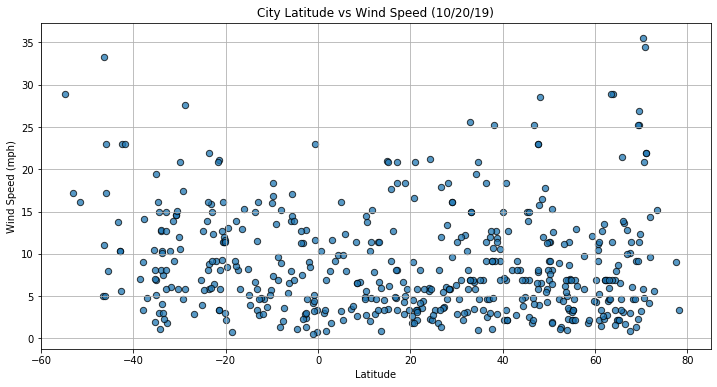

In [17]:
plt.figure(figsize=(12,6))
plt.scatter(lats, windspeed, marker="o", facecolors="tab:blue", edgecolors="black", s=40, alpha=0.75)
plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
plt.title(f"City Latitude vs Wind Speed ({data_date})")
plt.xlim(-60, 85)
#plt.ylim(0, 100)
plt.grid()
plt.savefig('output_data/CityLatvsWindSpeed.png')
plt.show()

In [18]:
# Print out a little performance data on the data gathering.

print (f"City, Country locations generated: {len(cities)}.") 
print (f"Total calls to API: {success_counter + fail_counter}.")
print (f"Successful API calls: {success_counter}.")
print (f"Failed API calls: {fail_counter}.") 
delay_ave = "{:.2f}".format(np.mean(delaylist))
delay_ave = "{:.0f}".format(np.mean(delaylist) * 1000)
print (f"Average loop delay: {delay_ave} milliseconds.")
print (f"Cities sampled: {composite_df.shape[0]}.")

City, Country locations generated: 627.
Total calls to API: 575.
Successful API calls: 500.
Failed API calls: 75.
Average loop delay: 684 milliseconds.
Cities sampled: 500.
